In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

from combat.pycombat import pycombat

from xgboost import XGBClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, cross_validate, StratifiedKFold
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif

from pymrmre import mrmr
from sklearn.base import BaseEstimator

import warnings
warnings.filterwarnings('ignore', module='pymrmre')
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
def data_load_preprocess():
    
    # load and drop all-NaN rows
    met_df = (pd.read_csv("./metabolomics/data_zscore_comp_id.csv"))
    met_df.set_index('Unnamed: 0', inplace=True)
    met_df.index.name = None
    met_df.dropna(axis=0, how='all', inplace=True)
    
    # drop rows containing >80% NaN
    perc = 0.8
    min_count =  int((1 - perc)*met_df.shape[1] + 1)
    met_df.dropna(axis=0, thresh=min_count, inplace=True)
    
    # fill rest of NaN values     
    met_df.fillna(0, inplace=True)
    met_df = met_df.T
    
    # batch effect correction
    clin_df = pd.read_csv("./metabolomics/sampleAttr.csv")
    met_df_corrected = pycombat(met_df.T, clin_df['STUDY'].values).T
    
    # drop outliers
    outliers = [17, 163, 222, 225, 255, 293, 362]
    met_df_corrected.drop(met_df_corrected.iloc[outliers].index, axis=0, inplace=True)
    
    # select patients who do not take aspirin     
    target = clin_df[['pe', 'ASA']]
    target.index = met_df.index
    df = met_df_corrected.join(target)
    df = df[df['ASA'] == False].copy(deep=True)
    df.drop(['ASA'], axis = 1, inplace=True)
    target = df['pe']
    df.drop(['pe'], axis=1, inplace=True)
    
    return df, target

In [3]:
class MRMR(BaseEstimator):
    def __init__(self, solution_length=1):
        self.solution_length = solution_length
        self.solution = []
        
    def fit(self, X_train, y_train):
        self.solution = mrmr.mrmr_ensemble(features=X_train, 
                                           targets=pd.DataFrame(y_train), 
                                           solution_length=self.solution_length, 
                                           solution_count=1).iloc[0][0]
        return self
        
    def transform(self, X_train):
        return X_train[self.solution]

In [4]:
class KBest(BaseEstimator):
    def __init__(self, score_func = f_classif, k=100):
        self.score_func = score_func
        self.k = k
        
    def fit(self, X_train, y_train):
        self.selector = SelectKBest(score_func=self.score_func, k=self.k)
        self.selector.fit(X_train, y_train)
        return self

        
    def transform(self, X_train):
        features = self.selector.get_support(indices=True)
        new_features = X_train.columns[features]
        
        return X_train[new_features]
        

In [5]:
def get_best_params(pipeline, params, X, y):
    grid = GridSearchCV(pipeline, param_grid=params, cv=5, 
                             scoring=['f1', 'roc_auc'], refit='f1')

    scores = cross_validate(grid, X, y, scoring=['accuracy', 'f1', 'roc_auc'],
                            cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=47))
    grid.fit(X, y)
    best_params = grid.best_params_

    return scores, best_params 

In [6]:
X, y = data_load_preprocess()

Found 4 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data


/home/lucija/.local/lib/python3.10/site-packages/combat/pycombat.py:159: RuntimeWarning: divide by zero encountered in divide
  np.absolute(d_new-d_old)/d_old))  # maximum difference between new and old estimate


In [7]:
params_kbest = {
    'kbest__score_func' : [f_classif, mutual_info_classif] ,
    'kbest__k' : [40, 60, 80, 100, 120, 140, 160, 180, 200, 220],
    'classifier__n_estimators' : [100, 200, 500],
    'classifier__max_depth' : [10, 20, 30]
}

model_kbest = Pipeline([('kbest', KBest()), ('scaler', StandardScaler()), ('classifier', XGBClassifier())])

scores_kbest, best_params_kbest = get_best_params(model_kbest, params_kbest, X, y)

# best_params_kbest = {
#     'classifier__max_depth': 10,
#     'classifier__n_estimators': 100,
#     'kbest__k' : 140,
#     'kbest__score_func' : f_classif
# }


# best_params_kbest = {
#     'classifier__max_depth': 10,
#     'classifier__n_estimators': 200,
#     'kbest__k': 40,
#     'kbest__score_func': f_classif
# }

model_kbest.set_params(**best_params_kbest)
model_kbest.fit(X, y)

Pipeline(steps=[('kbest', KBest(k=40)), ('scaler', StandardScaler()),
                ('classifier',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None,
                               early_stopping_rounds=None,
                               enable_categorical=False, eval_metric=None,
                               feature_types=None, gamma=None, gpu_id=None,
                               grow_policy=None, importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=10, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=200,
                               n_jobs=None, num_parallel_tree=None,
                               predictor=None, random_state=None, ...))])

In [8]:
params_mrmr = {
    'mrmr__solution_length' : [40, 60, 80, 100, 120, 140, 160, 180, 200, 220],
    'classifier__n_estimators' : [100, 200, 500],
    'classifier__max_depth' : [10, 20, 30]
}

model_mrmr = Pipeline([('mrmr', MRMR()), ('scaler', StandardScaler()), ('classifier', XGBClassifier())])

scores_mrmr, best_params_mrmr = get_best_params(model_mrmr, params_mrmr, X, y)

# best_params_mrmr = {
#     'classifier__max_depth': 10,
#     'classifier__n_estimators': 100,
#     'mrmr__solution_length': 120
# }

# best_params_mrmr = {
#     'classifier__max_depth': 10,
#     'classifier__n_estimators': 100,
#     'mrmr__solution_length': 40
# }

model_mrmr.set_params(**best_params_mrmr)
model_mrmr.fit(X, y)

Pipeline(steps=[('mrmr', MRMR(solution_length=40)),
                ('scaler', StandardScaler()),
                ('classifier',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None,
                               early_stopping_rounds=None,
                               enable_categorical=False, eval_metric=None,
                               feature_types=None, gamma=None, gpu_id=None,
                               grow_policy=None, importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=10, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=100,
                               n_jobs=None, num_parallel_tree=None,
                               predictor=None, random_state=None, ...))])

In [9]:
scores_mrmr

{'fit_time': array([307.36636376, 306.25228882, 325.61197495, 313.65118551,
        306.5383637 ]),
 'score_time': array([0.01570821, 0.01510549, 0.01685596, 0.0157218 , 0.01474524]),
 'test_accuracy': array([0.81967213, 0.78688525, 0.78688525, 0.6557377 , 0.6557377 ]),
 'test_f1': array([0.66666667, 0.64864865, 0.58064516, 0.4       , 0.46153846]),
 'test_roc_auc': array([0.84837093, 0.88095238, 0.84837093, 0.76463415, 0.6902439 ])}

In [10]:
scores_kbest

{'fit_time': array([1006.92296648, 1007.44742203, 1012.41200638, 1008.40179944,
        1006.52522278]),
 'score_time': array([0.01507545, 0.01467943, 0.01476455, 0.01439404, 0.01589751]),
 'test_accuracy': array([0.75409836, 0.62295082, 0.75409836, 0.60655738, 0.73770492]),
 'test_f1': array([0.51612903, 0.37837838, 0.51612903, 0.36842105, 0.57894737]),
 'test_roc_auc': array([0.8283208 , 0.67669173, 0.8358396 , 0.7       , 0.75731707])}

In [11]:
best_params_mrmr

{'classifier__max_depth': 10,
 'classifier__n_estimators': 100,
 'mrmr__solution_length': 40}

In [12]:
best_params_kbest

{'classifier__max_depth': 10,
 'classifier__n_estimators': 200,
 'kbest__k': 40,
 'kbest__score_func': <function sklearn.feature_selection._univariate_selection.f_classif(X, y)>}

In [13]:
model = model_kbest

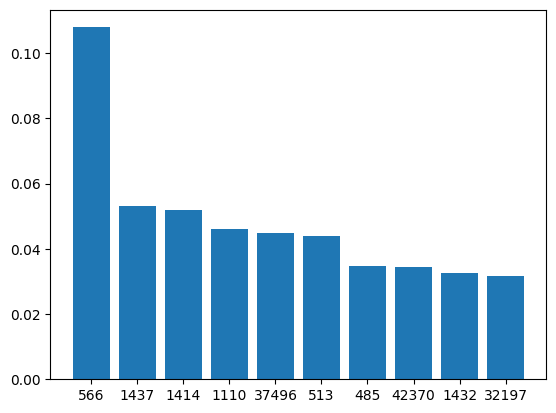

In [14]:
importances = sorted(zip(X.columns, model.steps[2][1].feature_importances_), key= lambda x: x[1], reverse=True)
values = [x[1] for x in importances[:10]]
labels = [x[0] for x in importances[:10]]

plt.bar(range(10), values)
plt.xticks(range(10), labels=labels)
plt.show()

In [15]:
comp_df = pd.read_csv('./metabolomics/compAnno.csv')

In [16]:
comp_df[comp_df.COMP_ID.isin(labels)]

,BIOCHEMICAL,PATHWAY_SORTORDER,SUPER_PATHWAY,SUB_PATHWAY,COMP_ID,PLATFORM,CHEMICAL_ID,PUBCHEM,CAS,KEGG,HMDB_ID
0,S-1-pyrroline-5-carboxylate,64.0,Amino Acid,Glutamate Metabolism,42370,Pos Early,35,11966181,2906-39-0,C04322,HMDB0001301
1,spermidine,553.0,Amino Acid,Polyamine Metabolism,485,Pos Early,50,1102,124-20-9,C00315,HMDB0001257
9,3-phosphoglycerate,1254.0,Carbohydrate,"Glycolysis, Gluconeogenesis, and Pyruvate Meta...",1414,Pos Early,132,724,80731-10-8,C00597,HMDB0000807
18,N-acetylputrescine,546.0,Amino Acid,Polyamine Metabolism,37496,Pos Early,192,122356,18233-70-0,C02714,HMDB0002064
25,arachidonate (20:4n6),1591.0,Lipid,Long Chain Polyunsaturated Fatty Acid (n3 and n6),1110,Neg,229,444899,506-32-1,C00219,HMDB0001043
28,2-hydroxyphenylacetate,161.0,Amino Acid,Phenylalanine Metabolism,1432,Polar,235,11970,614-75-5,C05852,HMDB0000669
29,3-(4-hydroxyphenyl)lactate,186.0,Amino Acid,Tyrosine Metabolism,32197,Neg,240,9378,6482-98-0,C03672,HMDB0000755
30,phenylpyruvate,155.0,Amino Acid,Phenylalanine Metabolism,566,Neg,241,997,156-06-9,C00166,HMDB0000205
33,succinate,1466.0,Energy,TCA Cycle,1437,Polar,252,1110,110-15-6,C00042,HMDB0000254
38,creatinine,537.0,Amino Acid,Creatine Metabolism,513,Pos Early,275,588,60-27-5,C00791,HMDB0000562


In [17]:
comp_df.SUPER_PATHWAY.unique()

array(['Amino Acid', 'Cofactors and Vitamins', 'Lipid', 'Energy',
       'Carbohydrate', 'Nucleotide', 'Peptide', 'Xenobiotics',
       'Partially Characterized Molecules', nan], dtype=object)

In [18]:
comp_df.SUB_PATHWAY.unique()

array(['Glutamate Metabolism', 'Polyamine Metabolism',
       'Nicotinate and Nicotinamide Metabolism', 'Fatty Acid, Dihydroxy',
       'Tryptophan Metabolism', 'TCA Cycle',
       'Leucine, Isoleucine and Valine Metabolism',
       'Mevalonate Metabolism',
       'Glycolysis, Gluconeogenesis, and Pyruvate Metabolism',
       'Primary Bile Acid Metabolism',
       'Pyrimidine Metabolism, Thymine containing',
       'Purine Metabolism, (Hypo)Xanthine/Inosine containing',
       'Long Chain Polyunsaturated Fatty Acid (n3 and n6)',
       'Medium Chain Fatty Acid', 'Lysine Metabolism',
       'Methionine, Cysteine, SAM and Taurine Metabolism',
       'Purine Metabolism, Adenine containing',
       'Urea cycle; Arginine and Proline Metabolism',
       'Alanine and Aspartate Metabolism', 'Phenylalanine Metabolism',
       'Tyrosine Metabolism', 'Pyrimidine Metabolism, Uracil containing',
       'Hemoglobin and Porphyrin Metabolism', 'Ketone Bodies', 'Sterol',
       'Phospholipid Metabolism

In [19]:
clin_df = pd.read_csv("./metabolomics/sampleAttr.csv")
clin_df['age'] = [float(x.replace(',', '.')) for x in clin_df['age']]
clin_df['weight'] = [float(x.replace(',', '.')) for x in clin_df['weight']]
clin_df['height'] = [float(x.replace(',', '.')) for x in clin_df['height']]
clin_df['BMI'] = clin_df['weight'] / (clin_df['height'] / 100)**2
clin_df['smoking'] = [1 if x == 'Smoker' or x == '1' else 0 for x in clin_df.smoking]

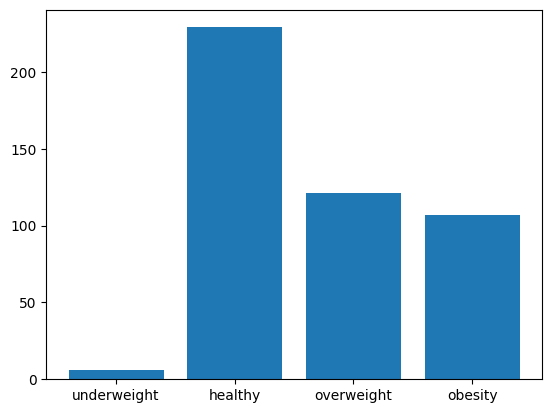

In [20]:
bmi = [clin_df[clin_df['BMI'] < 18.5].shape[0], 
 clin_df[clin_df['BMI'] < 25.0].shape[0] - clin_df[clin_df['BMI'] < 18.5].shape[0], 
 clin_df[clin_df['BMI'] >= 25].shape[0] - clin_df[clin_df['BMI'] >= 30].shape[0],
 clin_df[clin_df['BMI'] >= 30].shape[0]]

plt.bar(range(4), bmi)
plt.xticks(range(4), ['underweight', 'healthy', 'overweight', 'obesity'])
plt.show()

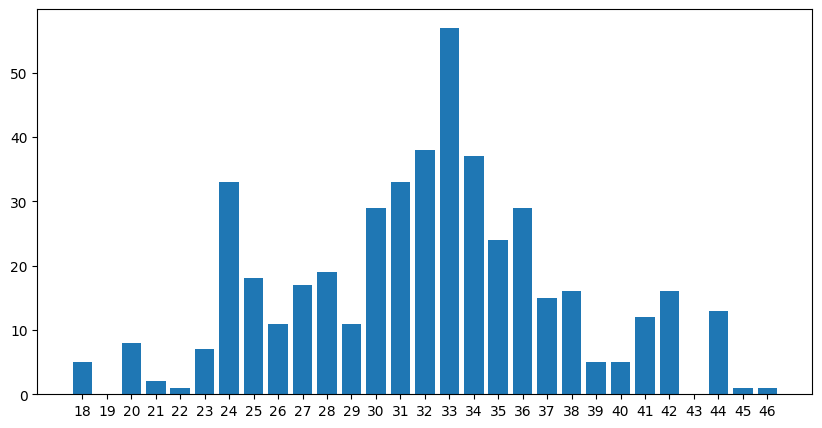

In [21]:
age = np.rint(clin_df.age).sort_values()

plt.figure(figsize=(10, 5))
plt.bar(range(18, 47), np.bincount(age)[18:])
plt.xticks(range(18, 47))
plt.show()

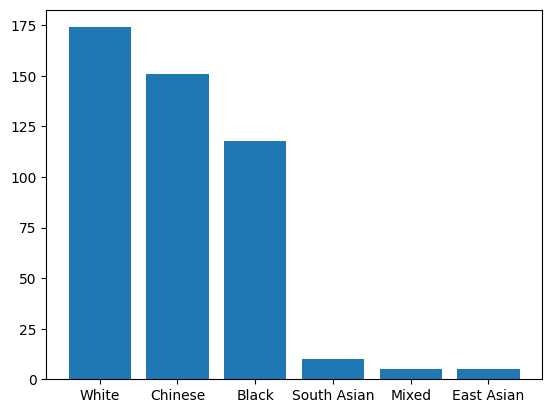

In [22]:
race = clin_df.race.value_counts()

plt.bar(range(race.shape[0]), race)
plt.xticks(range(race.shape[0]), labels=race.index)
plt.show()

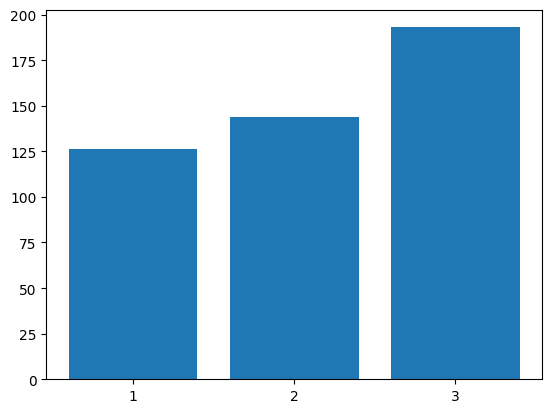

In [23]:
trimester = clin_df.trimester.value_counts().sort_index()
plt.bar(range(trimester.shape[0]), trimester)
plt.xticks(range(trimester.shape[0]), labels=trimester.index)
plt.show()

In [24]:
from scipy import stats

In [25]:
def stat_test(test_type):
    p_dict = {}
    test = clin_df[['trimester', 'sIDs', 'pe']].join(X, on='sIDs', how='right')

    for c in X.columns:
        for t in range(1, 4):
            trim = test[test.trimester == t]
            group1 = trim[trim.pe == 1][c]
            group2 = trim[trim.pe == 0][c]
            t_stat, p_value = test_type(group1, group2)
            if(p_value < 0.05):
                p_dict[(c, t)] = (p_value)

    return p_dict


In [26]:
res = stat_test(stats.ttest_ind)

/tmp/ipykernel_19541/795192912.py:10: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  t_stat, p_value = test_type(group1, group2)


In [27]:
len(res)

305

In [28]:
res

{(485, 1): 0.0012373127876819587,
 (485, 2): 0.01563922395862706,
 (528, 1): 0.029227307515029593,
 (1417, 3): 0.0002388931934056716,
 (1414, 2): 0.002315540084132495,
 (1418, 2): 0.03956116099234835,
 (1418, 3): 0.0059121974856313365,
 (3127, 1): 0.0020804937001622464,
 (3127, 2): 0.004186131549440144,
 (2829, 3): 0.022367174130222284,
 (32342, 1): 2.8562807816084667e-05,
 (32342, 2): 5.7257736835658004e-05,
 (558, 3): 0.007721728386456898,
 (1110, 3): 0.033844737363283035,
 (1638, 2): 0.04337439036619761,
 (443, 1): 0.0006597240407637627,
 (443, 2): 0.01983182798375823,
 (32197, 3): 0.0002619446434470324,
 (566, 1): 0.01573904288186263,
 (1437, 2): 0.001290247439252193,
 (34396, 1): 0.03583502591729961,
 (1769, 1): 0.004657017862818709,
 (35637, 1): 0.0043973849371740144,
 (35637, 2): 0.004692583650987894,
 (17747, 2): 0.007911059318841325,
 (36738, 1): 9.417972341575433e-06,
 (36738, 2): 0.002934418718544969,
 (43802, 3): 0.04792177718941805,
 (1712, 3): 0.00025472914272732457,
 (59

In [29]:
res = stat_test(stats.mannwhitneyu)

In [30]:
len(res)

409

In [31]:
res

{(485, 1): 0.002306842541692991,
 (437, 1): 0.00019954954592728668,
 (437, 2): 0.03297355773896367,
 (1417, 3): 6.387689111075936e-05,
 (1414, 2): 0.003673806733242908,
 (1418, 2): 0.04025820038528168,
 (1418, 3): 0.010409457715826458,
 (3127, 1): 0.005117863477786534,
 (3127, 2): 0.0059394743035875615,
 (1105, 3): 0.02199571782608129,
 (1645, 3): 0.045607740279314385,
 (2829, 3): 0.013784115770092477,
 (32342, 1): 7.879327119765716e-05,
 (32342, 2): 0.002816847241748476,
 (558, 1): 0.0011049921635827987,
 (443, 1): 0.0025161417211203014,
 (443, 2): 0.030393406283480664,
 (1432, 1): 0.03605246721739048,
 (32197, 3): 0.00029417546591002175,
 (566, 1): 0.01847425043047854,
 (2137, 3): 0.047874357367763735,
 (1437, 2): 0.0018398562587833751,
 (34396, 1): 0.039821892314669725,
 (1769, 1): 0.04950318980769836,
 (35637, 1): 0.0035254400881534176,
 (35637, 2): 0.04745337215909515,
 (17747, 2): 0.021856386127924333,
 (36738, 1): 1.7118509416377338e-05,
 (36738, 2): 0.004788148460319501,
 (1712

In [32]:
stats.shapiro(X[57])

ShapiroResult(statistic=0.9411064386367798, pvalue=1.138236283004801e-09)

In [33]:
proba = {}
for c in X.columns:
    s, p = stats.shapiro(X[c])
    if p > 0.05:
        proba[c] = p
        
proba

{63: 0.34283629059791565,
 1769: 0.3209894597530365,
 59: 0.2127142995595932,
 1125: 0.08839824050664902,
 1301: 0.17088158428668976,
 54: 0.8498886823654175,
 1649: 0.08149401098489761,
 1585: 0.08519928902387619,
 1604: 0.3414900302886963,
 2730: 0.19988402724266052,
 17945: 0.16799920797348022,
 15506: 0.11534703522920609,
 42446: 0.6255286335945129,
 52461: 0.06974275410175323,
 20675: 0.09745470434427261,
 52449: 0.6167104840278625,
 33955: 0.28351595997810364,
 33947: 0.5474231243133545,
 46173: 0.4463614225387573,
 42450: 0.1905202865600586,
 37506: 0.7296955585479736,
 42463: 0.5860546231269836,
 42459: 0.533799409866333,
 48491: 0.17698021233081818,
 48492: 0.8747414350509644,
 48493: 0.1717955321073532,
 57330: 0.5342803001403809,
 52433: 0.07880964130163193,
 52603: 0.19753548502922058,
 52610: 0.05742896720767021,
 52434: 0.9222029447555542,
 52436: 0.510481059551239,
 52446: 0.9134305119514465,
 52452: 0.33701175451278687,
 52468: 0.9127631187438965,
 52478: 0.052617751061

In [34]:
importances

[(566, 0.10796145),
 (1437, 0.05322025),
 (1414, 0.051983546),
 (1110, 0.045939125),
 (37496, 0.044799883),
 (513, 0.0438561),
 (485, 0.034697052),
 (42370, 0.03434009),
 (1432, 0.032476056),
 (32197, 0.03182749),
 (528, 0.029648682),
 (38395, 0.02963765),
 (1645, 0.02851314),
 (1899, 0.02796762),
 (437, 0.027832966),
 (558, 0.023203362),
 (35637, 0.022984464),
 (63, 0.022950437),
 (37114, 0.021175463),
 (1418, 0.020923145),
 (32342, 0.020085096),
 (38399, 0.01883528),
 (34396, 0.018558253),
 (27665, 0.01778238),
 (1417, 0.017734773),
 (542, 0.017051632),
 (22842, 0.015939279),
 (1498, 0.01458024),
 (443, 0.014319696),
 (531, 0.013047522),
 (1549, 0.0129254395),
 (3127, 0.011280774),
 (1769, 0.011152559),
 (1638, 0.011021355),
 (2829, 0.010952223),
 (42382, 0.010337764),
 (2137, 0.009765969),
 (1105, 0.008895722),
 (1419, 0.0054972162),
 (55, 0.0042988053)]

In [35]:
def statistic(test_type):
    p_dict = {}
    test = clin_df[['trimester', 'sIDs', 'pe']].join(X, on='sIDs', how='right')

    for c in X.columns:
        group1 = test[test.pe == 1][c]
        group2 = test[test.pe == 0][c]
        t_stat, p_value = test_type(group1, group2)
        if(p_value < 0.05):
            p_dict[c] = p_value

    return p_dict


In [36]:
res = statistic(stats.mannwhitneyu)

In [37]:
importance_dict = {}
v = [x[0] for x in importances]
for m, p in res.items():
    if(m not in v):
        continue
    else:
        importance_dict[m] = v.index(m)


In [38]:
sorted(importance_dict.items(), key=lambda x: x[1])

[(32197, 9),
 (437, 14),
 (1417, 24),
 (1769, 32),
 (2829, 34),
 (42382, 35),
 (1105, 37)]